In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

In [2]:
# load a pair of images
fname = os.path.join('T1Images','subject2D_83_target.img')
imgI = nib.load(fname)
nx = imgI.header['dim'][1:4]
dx = imgI.header['pixdim'][1:4]
# set up a domain
x0 = np.arange(nx[0])*dx[0] - np.mean(np.arange(nx[0])*dx[0])
x1 = np.arange(nx[1])*dx[1] - np.mean(np.arange(nx[1])*dx[1])
X0,X1 = np.meshgrid(x0,x1,indexing='ij')

fname = os.path.join('T1Images','template2D_83_template.img')
imgJ = nib.load(fname)

<IPython.core.display.Javascript object>


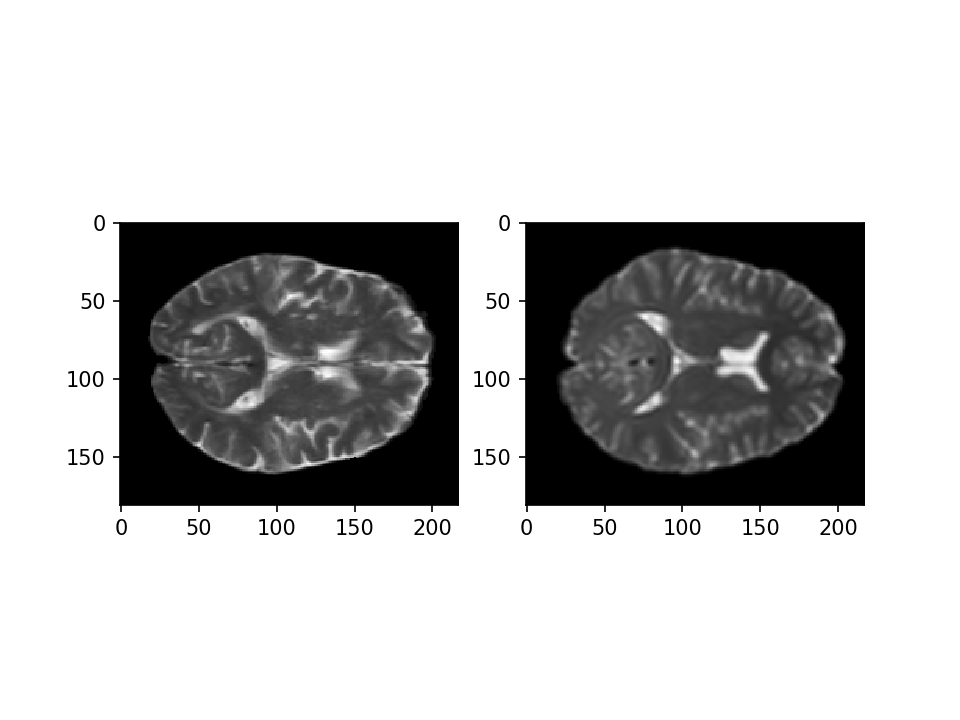

In [3]:
# start with a 2D example
I = imgI.get_data()[:,:,imgI.shape[2]//2,0] # note last axes is time, we'd like to remove it
J = imgJ.get_data()[:,:,imgJ.shape[2]//2,0] # note last axes is time, we'd like to remove it

f,ax = plt.subplots(1,2)
ax[0].imshow(I,cmap='gray')
ax[0].set_aspect('equal')
ax[1].imshow(J,cmap='gray')
ax[1].set_aspect('equal')

In [4]:
# example deformation and action on image
gaussian = np.exp(-(X0**2 + X1**2)/(2.0*30.0**2))
magnitudes = [20,40,60,80,100]

<IPython.core.display.Javascript object>


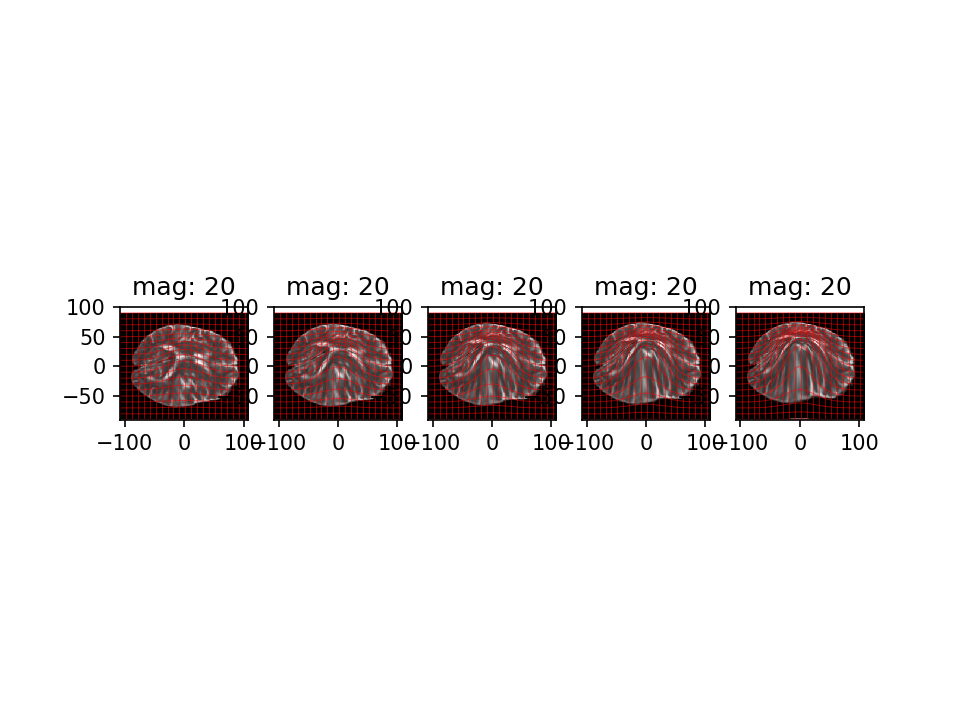

In [5]:
f,ax = plt.subplots(1,len(magnitudes),sharex=True)

mag = magnitudes[0]
interp_args = dict(bounds_error=False,fill_value=0,method='linear')
stride = 10
imshow_args = dict(cmap='gray',extent=[x1[0],x1[-1],x0[0],x0[-1]],origin='lower')
    
phi0 = np.array(X0)
phi1 = np.array(X1)
phiinv0 = np.array(X0)
phiinv1 = np.array(X1)
for a in ax:
    v0 = gaussian*mag
    v1 = np.zeros_like(v0)
    # update using composition
    # recall that on a computer, composition is just interpolation
    phi0_ = phi0 + spi.interpn([x0,x1],v0,np.stack([phi0,phi1],axis=-1),**interp_args)
    phi1 = phi1 + spi.interpn([x0,x1],v1,np.stack([phi0,phi1],axis=-1),**interp_args)
    phi0 = phi0_
    
    # update to the inverse
    phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0-v0,X1-v1],axis=-1),**interp_args)
    phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0-v0,X1-v1],axis=-1),**interp_args)
    
    phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    
    a.imshow(phiI,**imshow_args)
    ss.plot_grid(phi1,phi0,ax=a,rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
    a.set_aspect('equal')
    a.set_title('mag: {}'.format(mag))
    

<IPython.core.display.Javascript object>


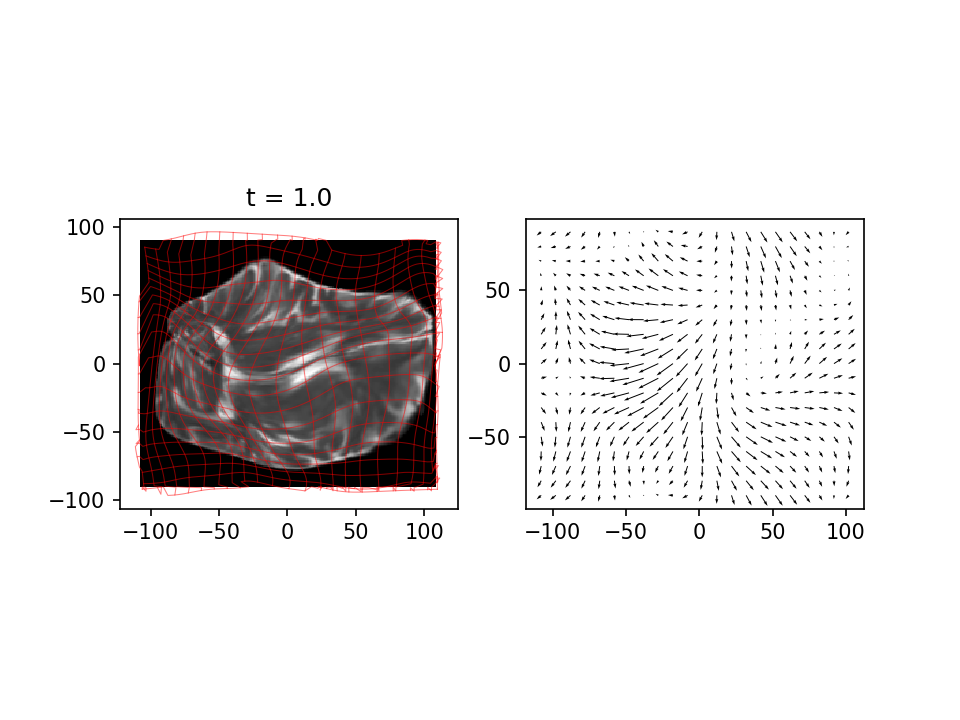

In [6]:
# example of flows
nt = 5
dt = 1.0/nt

# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
F0,F1 = np.meshgrid(f0,f1,indexing='ij')
a = 10.0 # a scale in mm
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.ifft2(Khat,nx[:2]).real

# make a random flow
mag = 2000.0
vt0 = np.random.randn(nx[0],nx[1],nt)*mag
vt1 = np.random.randn(nx[0],nx[1],nt)*mag
# smooth it
vt0 = np.fft.ifftn(np.fft.fftn(vt0,axes=[0,1])*Khat[:,:,None],axes=[0,1]).real
vt1 = np.fft.ifftn(np.fft.fftn(vt1,axes=[0,1])*Khat[:,:,None],axes=[0,1]).real

# now lets flow it forward
phi0 = np.array(X0)
phi1 = np.array(X1)
phiinv0 = np.array(X0)
phiinv1 = np.array(X1)

f,ax = plt.subplots(1,2)
for t in range(nt):
    v0 = vt0[:,:,t]
    v1 = vt1[:,:,t]
    # update phi using Euler's equation    
    phi0_ = phi0 + spi.interpn([x0,x1],v0,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
    phi1 = phi1 + spi.interpn([x0,x1],v1,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
    phi0 = phi0_
    
    # update phiinv using method of characteristics
    X0s = X0-v0*dt
    X1s = X1-v1*dt
    interp_args_phiinv = dict(interp_args)
    interp_args_phiinv['fill_value'] = None
    #phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
    #phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
    # here we need to deal with boundary conditions better
    phiinv0 = spi.interpn([x0,x1],phiinv0-X0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X0s
    phiinv1 = spi.interpn([x0,x1],phiinv1-X1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X1s
    
    # act on the image
    phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)

    [a.cla() for a in ax]
    ax[0].imshow(phiI,**imshow_args)
    ss.plot_grid(phi1,phi0,ax=ax[0],rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
    ax[0].set_aspect('equal')
    ax[0].set_title('t = {:3.1f}'.format((t+1)*dt))
    
    ax[1].quiver(X1[::stride,::stride],X0[::stride,::stride],
             v1[::stride,::stride],v0[::stride,::stride])
    ax[1].set_aspect('equal')    
    f.canvas.draw()

<IPython.core.display.Javascript object>


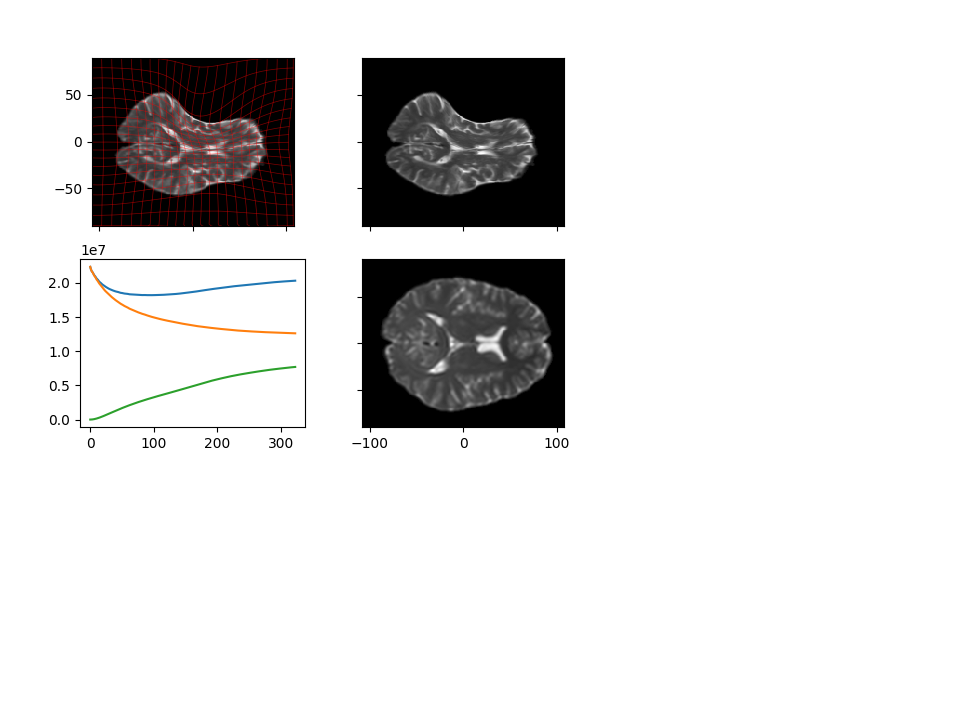

In [ ]:
# now run matching
# for display, create plots with shared axis
f,ax = plt.subplots(2,2,sharex=True,sharey=True)
# for plotting energy, no shared axis
f.delaxes(ax[1][0])
ax[1][0] = f.add_subplot(2,2,3)

# parameters
sigma = 2e0
niter = 500
epsilon = 2.0e-2

# initialize
vt0 = np.zeros((nx[0],nx[1],nt))
vt1 = np.zeros((nx[0],nx[1],nt))
It = np.zeros((nx[0],nx[1],nt+1))
It[:,:,0] = I

EMAll = []
ERAll = []
EAll = []
for it in range(niter):
    # compute the deformed image by flowing over time
    phi0 = X0
    phi1 = X1
    phiinv0 = X0
    phiinv1 = X1
    ER = 0.0
    for t in range(nt):
        v0 = vt0[:,:,t]
        v1 = vt1[:,:,t]
        # update phi using Euler's equation   
        # this is not necessary for the algorithm, only visualization
        phi0_ = phi0 + spi.interpn([x0,x1],v0,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
        phi1 = phi1 + spi.interpn([x0,x1],v1,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
        phi0 = phi0_

        # update phiinv using method of characteristics
        X0s = X0-v0*dt
        X1s = X1-v1*dt
        #phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        #phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        # here we need to deal with boundary conditions better
        phiinv0 = spi.interpn([x0,x1],phiinv0-X0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X0s
        phiinv1 = spi.interpn([x0,x1],phiinv1-X1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X1s

        # act on the image
        It[:,:,t+1] = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    
        # calculate the energy of the flow
        Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
        Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
        ER += np.sum(v0*Av0 + v1*Av1)*0.5*dx[0]*dx[1]*dt
        
    ax[0,0].cla()
    ax[0,0].imshow(It[:,:,-1],**imshow_args)
    ss.plot_grid(phi1,phi0,ax=ax[0,0],color='r',alpha=0.5,linewidth=0.5,rstride=stride,cstride=stride)
    
    # error
    err = It[:,:,-1] - J
    lambda1 = -(err)/sigma**2
    ax[0,1].cla()
    ax[0,1].imshow(err,**imshow_args)
    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]
    EMAll.append(EM)        
    ERAll.append(ER)    
    E = ER+EM
    EAll.append(E)
    ax[1,0].cla()
    ax[1][0].plot(EAll)
    ax[1][0].plot(EMAll)
    ax[1][0].plot(ERAll)
    
    # now we start flowing the error back in time
    phiinv0 = X0
    phiinv1 = X1
    for t in range(nt-1,-1,-1):
        v0 = vt0[:,:,t]
        v1 = vt1[:,:,t]
        
        # update phiinv using method of characteristics
        X0s = X0+v0*dt
        X1s = X1+v1*dt
        #phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        #phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        # here we need to deal with boundary conditions better
        phiinv0 = spi.interpn([x0,x1],phiinv0-X0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X0s
        phiinv1 = spi.interpn([x0,x1],phiinv1-X1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X1s
        
        # find the determinant of Jacobian
        phiinv0_0,phiinv0_1 = np.gradient(phiinv0,dx[0],dx[1])
        phiinv1_0,phiinv1_1 = np.gradient(phiinv1,dx[0],dx[1])
        detjac = phiinv0_0*phiinv1_1 - phiinv0_1*phiinv1_0
        
        # find lambda_t
        lambdat = spi.interpn([x0,x1],lambda1,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)*detjac
        
        # get the gradient of the image at this time
        I_0,I_1 = np.gradient(It[:,:,t],dx[0],dx[1])
        
        # initialize the gradient with the matching term
        grad0 = lambdat*I_0
        grad1 = lambdat*I_1
        
        # smooth it
        grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
        grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real

        # add the regularization term
        grad0 += v0
        grad1 += v1

        # update
        vt0[:,:,t] -= epsilon*grad0
        vt1[:,:,t] -= epsilon*grad1
        
    ax[1][1].imshow(J,**imshow_args)
    ax[1][1].set_aspect('equal')
    f.canvas.draw()